## Импорты

In [1]:
%pip install optuna
%pip install hyperopt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split, cross_val_score, cross_validate, HalvingGridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import time
import os
import joblib
import optuna
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
from hyperopt.pyll import scope

## Загрузка датасета

In [3]:
df = pd.read_csv('train.csv', index_col='id')
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


## Разделение выборки

In [4]:
df_sample = df.sample(n=1_500_000, random_state=42)

X = df_sample.drop("Response", axis=1)
y = df_sample["Response"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=1_000_000,
    test_size=500_000,
    stratify=y,
    random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Class balance in train:\n{y_train.value_counts(normalize=True)}")

Train shape: (1000000, 10)
Test shape: (500000, 10)
Class balance in train:
Response
0    0.876795
1    0.123205
Name: proportion, dtype: float64


## ThresholdFrequencyEncoder

Группирует редкие категории в 'OTHER' и кодирует частотой встречаемости.

**Параметры:**

- **`threshold`** (`float`) — минимальная доля для отдельной категории  
  *По умолчанию: `0.01` (1%)*  

- **`other_name`** (`str`) — название для группы редких категорий  
  *По умолчанию: `"OTHER"`* 

In [5]:
class ThresholdFrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.01, other_name='OTHER'):
        self.threshold = threshold
        self.other_name = other_name
        self.freq_maps_ = {}
        self.columns_ = []

    def fit(self, X, y=None):
        self.columns_ = X.columns.tolist()
        
        for col in self.columns_:
            # Считаем частоты всех категорий
            value_counts = X[col].value_counts(normalize=True)
            
            # Определяем, какие категории встречаются достаточно часто
            common_categories = value_counts[value_counts >= self.threshold].index
            
            # Создаём маппинг для частотного кодирования
            freq_map = {}
            
            # Для частых категорий сохраняем их реальную частоту
            for cat in common_categories:
                freq_map[cat] = value_counts[cat]

            # Для редких категорий используем суммарную частоту
            other_categories = value_counts[value_counts < self.threshold].index
            other_freq = value_counts[other_categories].sum() if len(other_categories) > 0 else 0
            
            freq_map[self.other_name] = other_freq
            
            # Сохраняем маппинг
            self.freq_maps_[col] = freq_map
        
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        for col in self.columns_:
            if col not in X_copy.columns:
                continue
            
            # Создаём временную колонку для преобразований
            temp_col = X_copy[col].astype(str)
            
            # Группируем редкие категории в OTHER
            common_categories = list(self.freq_maps_[col].keys())
            common_categories.remove(self.other_name)
            
            # Заменяем редкие категории на OTHER
            temp_col = temp_col.where(
                temp_col.isin(common_categories), 
                other=self.other_name
            )
            
            # Применяем частотное кодирование
            encoded_values = temp_col.map(self.freq_maps_[col])
            
            # Заполняем пропуски (новые категории получают частоту OTHER)
            encoded_values = encoded_values.fillna(self.freq_maps_[col][self.other_name])
            
            # Заменяем исходную колонку
            X_copy[col] = encoded_values
        
        return X_copy

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return self.columns_
        return input_features

In [6]:
high_card_cols = ['Region_Code', 'Policy_Sales_Channel']
bool_cols = ['Gender', 'Vehicle_Damage']
ord_cols = ['Vehicle_Age']

preprocessor = ColumnTransformer(
    transformers=[
        ("high_cat", ThresholdFrequencyEncoder(threshold=0.01, other_name='OTHER'), high_card_cols),
        ("bool", OneHotEncoder(drop='first', sparse_output=False, dtype=np.int32), bool_cols),
        ("ord", OrdinalEncoder(
            categories=[['< 1 Year', '1-2 Year', '> 2 Years']],
            dtype=np.int32
        ), ord_cols),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Модель градиентного бустинга

### Подбор гиперпараметров методом GridSearchCV

**Параметры для GridSearchCV:**

- **`n_estimators`** `[100, 200]` — Количество деревьев в ансамбле: 100-200 даёт баланс между качеством и временем обучения 
- **`max_depth`** `[3, 5]` — Глубина деревьев: 3-5 предотвращает переобучение на редком классе
- **`learning_rate`** `[0.05, 0.1]` — Скорость обучения: меньшие значения (0.05) лучше для дисбаланса, 0.1 - стандарт
- **`subsample`** `[0.7, 0.8]` — Каждое дерево обучается на 70-80% случайных данных, что меняет соотношение классов и улучшает устойчивость

In [7]:
GRIDSEARCH_FILE = 'gridsearch_boost_result.pkl'

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__subsample': [0.7, 0.8]  # помогает с дисбалансом
}

sample_weights = compute_sample_weight('balanced', y_train) # Автоматически вычисляет веса для каждого объекта. Чем реже класс, тем больше вес его объектов

grid_search = GridSearchCV(
    estimator=full_pipeline,
    param_grid=param_grid,
    scoring='f1',  # метрика для несбалансированных данных
    cv=cv,
    n_jobs=-1, # использовать все доступные ядра процессора
    verbose=1 # прогресс-бар (сколько выполнено/осталось)
)

if os.path.exists(GRIDSEARCH_FILE):
    print("Загружаем сохраненный GridSearch...")
    grid_search = joblib.load(GRIDSEARCH_FILE)
    print("GridSearch загружен")
else:
    print("Запуск GridSearchCV...")
    start_time = time.time()
    grid_search.fit(X_train, y_train, classifier__sample_weight=sample_weights)
    end_time = time.time()
    print(f"GridSearch завершен за {(end_time - start_time)/60:.1f} минут")
    joblib.dump(grid_search, GRIDSEARCH_FILE)

Загружаем сохраненный GridSearch...
GridSearch загружен


### Подбор гиперпараметров методом RandomizedSearchCV

Задаем более расширенные параметры и исследуем 6×6×5×6×5×5 = 27,000 возможных комбинаций (в GridSearch было 16). Но за счёт случайного выбора 16 комбинаций (как в GridSearch) мы тратим то же время на обучение (80 фитов), но покрываем гораздо большее пространство.

**Дополнительные параметры для RandomizedSearchCV:**

- **`min_samples_split`** `[2, 5, 10, 20, 30]` — Минимальное количество образцов для разделения узла. Контролирует переобучение на редком классе, объединяя редкие случаи.
- **`min_samples_leaf`** `[1, 2, 5, 10, 15]` — Минимальное количество образцов в листе. Увеличивает устойчивость листьев.

**Ожидаемый результат:**
RandomizedSearch может найти комбинацию лучше GridSearch, так как проверяет более широкое пространство параметров за то же время.

In [8]:
RANDOMSEARCH_FILE = 'randomsearch_boost_result.pkl'

param_random = {
    'classifier__n_estimators': [50, 100, 150, 200, 250, 300],
    'classifier__max_depth': [2, 3, 4, 5, 6, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'classifier__subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
    'classifier__min_samples_split': [2, 5, 10, 20, 30],
    'classifier__min_samples_leaf': [1, 2, 5, 10, 15]
}

n_iter_random = 16  # Проверим 16 случайных комбинаций

sample_weights = compute_sample_weight('balanced', y_train) # Автоматически вычисляет веса для каждого объекта. Чем реже класс, тем больше вес его объектов

random_search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=param_random,
    n_iter=n_iter_random,  # Те же 16 комбинаций, что и в GridSearch
    scoring='f1',  # Метрика для несбалансированных данных
    cv=cv,  # 5 фолдов (как в GridSearch)
    n_jobs=-1,  # Используем все ядра процессора
    verbose=1,  # Прогресс-бар
    random_state=42,  # Для воспроизводимости
    return_train_score=True  # Для анализа переобучения
)

if os.path.exists(RANDOMSEARCH_FILE):
    print("Загружаем сохраненный RandomSearch...")
    random_search = joblib.load(RANDOMSEARCH_FILE)
    print("RandomSearch загружен")
else:
    print(f"Запуск RandomizedSearchCV с расширенными параметрами...")
    start_time = time.time()
    random_search.fit(X_train, y_train, classifier__sample_weight=sample_weights)
    end_time = time.time()
    print(f"\nRandomizedSearch завершен за {(end_time - start_time)/60:.1f} минут")
    joblib.dump(random_search, RANDOMSEARCH_FILE)

Загружаем сохраненный RandomSearch...
RandomSearch загружен


### Подбор гиперпараметров методом Optuna

In [9]:
OPTUNA_FILE = 'optuna_boost_result.pkl'

def objective(trial):
    """
    Целевая функция для Optuna - оптимизирует F1-score
    Используем существующий full_pipeline и обновляем параметры классификатора
    """
    
    # Значения параметров для каждого испытания (trial)
    params = {
        'classifier__n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'classifier__max_depth': trial.suggest_int('max_depth', 2, 7),
        'classifier__learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'classifier__subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'classifier__min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
        'classifier__min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 15)
    }
    
    # Копируем существующий pipeline чтобы не изменять оригинал
    temp_pipeline = clone(full_pipeline)
    
    # Обновляем параметры в пайплайне
    temp_pipeline.set_params(**params)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Вычисляем веса для текущего фолда
        fold_weights = compute_sample_weight('balanced', y_train_fold)

        fold_pipeline = clone(temp_pipeline)
        fold_pipeline.fit(X_train_fold, y_train_fold, classifier__sample_weight=fold_weights)

        y_pred = fold_pipeline.predict(X_val_fold)
        score = f1_score(y_val_fold, y_pred)
        scores.append(score)

    return np.mean(scores)

In [10]:
sample_weights = compute_sample_weight('balanced', y_train)

# Создаем исследование Optuna (максимизируем F1-score)
optuna_study = optuna.create_study(
    direction='maximize',  # максимизируем F1-score
    study_name='gradient_boosting_optuna',
    sampler=optuna.samplers.TPESampler(seed=42)  # Используем TPE (байесовский метод)
)

if os.path.exists(OPTUNA_FILE):
    print("Загружаем сохраненное исследование Optuna...")
    optuna_study = joblib.load(OPTUNA_FILE)
    print("Исследование Optuna загружено")
else:
    print("Запуск Optuna...")
    # Запускаем оптимизацию
    start_time = time.time()
    optuna_study.optimize(objective, n_trials=30, show_progress_bar=True)
    end_time = time.time()
    print(f"Optuna завершена за {(end_time - start_time)/60:.1f} минут")
    joblib.dump(optuna_study, OPTUNA_FILE)

[I 2025-12-16 22:18:32,809] A new study created in memory with name: gradient_boosting_optuna


Загружаем сохраненное исследование Optuna...
Исследование Optuna загружено


### Подбор гиперпараметров методом Hyperopt

In [11]:
HYPEROPT_FILE = 'hyperopt_boost_result.pkl'

hyperopt_space = {
    'classifier__n_estimators': scope.int(hp.quniform('classifier__n_estimators', 50, 300, 1)),
    'classifier__max_depth': scope.int(hp.quniform('classifier__max_depth', 2, 7, 1)),
    'classifier__learning_rate': hp.loguniform('classifier__learning_rate', np.log(0.01), np.log(0.2)),
    'classifier__subsample': hp.uniform('classifier__subsample', 0.6, 0.9),
    'classifier__min_samples_split': scope.int(hp.quniform('classifier__min_samples_split', 2, 30, 1)),
    'classifier__min_samples_leaf': scope.int(hp.quniform('classifier__min_samples_leaf', 1, 15, 1))
}

# Функция-объектив для Hyperopt (минимизируем -F1)
def hyperopt_objective(params):
    """
    Целевая функция для Hyperopt - оптимизирует F1-score
    Используем существующий full_pipeline и обновляем параметры классификатора
    """
    
    try:
        # Копируем существующий pipeline чтобы не изменять оригинал
        temp_pipeline = clone(full_pipeline)
        
        # Обновляем параметры в пайплайне
        temp_pipeline.set_params(**params)
        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = []

        for train_idx, val_idx in cv.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Вычисляем веса для текущего фолда
            fold_weights = compute_sample_weight('balanced', y_train_fold)

            fold_pipeline = clone(temp_pipeline)
            fold_pipeline.fit(X_train_fold, y_train_fold, classifier__sample_weight=fold_weights)

            y_pred = fold_pipeline.predict(X_val_fold)
            score = f1_score(y_val_fold, y_pred)
            scores.append(score)

        average_f1 = np.mean(scores)
        
        # Hyperopt минимизирует loss, поэтому возвращаем отрицательный F1-score
        # В Optuna мы максимизировали F1-score, здесь мы минимизируем -F1-score
        return -average_f1
        
    except Exception as e:
        # В случае ошибки возвращаем очень плохое значение (максимальный loss)
        print(f"Ошибка при оценке параметров: {e}")
        return 1.0  # Максимально плохой F1-score (0 в терминах F1)

In [12]:
# Инициализируем объект Trials для хранения истории
hyperopt_trials = Trials()

# Проверяем наличие сохраненного исследования Hyperopt
if os.path.exists(HYPEROPT_FILE):
    print("Загружаем сохраненное исследование Hyperopt...")
    hyperopt_data = joblib.load(HYPEROPT_FILE)
    hyperopt_trials = hyperopt_data['trials']
    hyperopt_best = hyperopt_data['best']
    print("Исследование Hyperopt загружено")
else:
    print("Запуск Hyperopt...")
    
    hyperopt_trials = Trials()
    
    start_time = time.time()
    
    hyperopt_best = fmin(
        fn=hyperopt_objective,
        space=hyperopt_space,
        algo=tpe.suggest,
        max_evals=30,
        trials=hyperopt_trials,
        show_progressbar=True,
        rstate=np.random.default_rng(42),  # Для воспроизводимости
        verbose=1
    )
    
    end_time = time.time()
    print(f"Hyperopt завершена за {(end_time - start_time)/60:.1f} минут")
    
    hyperopt_data = {
        'trials': hyperopt_trials,
        'best': hyperopt_best
    }
    joblib.dump(hyperopt_data, HYPEROPT_FILE)

Загружаем сохраненное исследование Hyperopt...
Исследование Hyperopt загружено


### Подбор гиперпараметров методом HalvingGridSearchCV

In [13]:
HALVING_FILE = 'halving_boost_result.pkl'

halving_param = {
    'classifier__n_estimators': [50, 100, 150, 200, 250, 300],
    'classifier__max_depth': [2, 3, 4, 5, 6, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'classifier__subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
    'classifier__min_samples_split': [2, 5, 10, 20, 30],
    'classifier__min_samples_leaf': [1, 2, 5, 10, 15]
}

# Создаем HalvingGridSearchCV
halving_search = HalvingGridSearchCV(
    estimator=full_pipeline,
    param_grid=param_grid,
    factor=3,  # На каждой итерации оставляем 1/3 кандидатов
    cv=cv,  # Используем то же количество фолдов (5)
    scoring='f1',  # Оптимизируем F1-score
    n_jobs=-1,  # Используем все доступные ядра
    verbose=1,  # Выводим прогресс
    random_state=42,  # Для воспроизводимости
    refit=True,  # Переобучаем лучшую модель на всех данных
    error_score='raise'  # Прерываем при ошибке
)

In [14]:
# Проверяем наличие сохраненных результатов
if os.path.exists(HALVING_FILE):
    print("Загружаем сохраненный HalvingGridSearchCV...")
    halving_search = joblib.load(HALVING_FILE)
    print("HalvingGridSearchCV загружен")
else:
    print("Запуск HalvingGridSearchCV...")
    
    # Запускаем поиск
    start_time = time.time()
    halving_search.fit(X_train, y_train, classifier__sample_weight=sample_weights)
    end_time = time.time()
    
    print(f"HalvingGridSearchCV завершен за {(end_time - start_time)/60:.1f} минут")
    
    # Сохраняем результаты
    joblib.dump(halving_search, HALVING_FILE)
    print("Результаты HalvingGridSearchCV сохранены")

Загружаем сохраненный HalvingGridSearchCV...
HalvingGridSearchCV загружен


## Оценка моделей

In [15]:
print(optuna_study.best_trial.params)
print(grid_search.best_params_)
print(random_search.best_params_)
print(hyperopt_data['best'])
print(halving_search.best_params_)

{'n_estimators': 245, 'max_depth': 7, 'learning_rate': 0.15604312608566637, 'subsample': 0.8182611788035248, 'min_samples_split': 14, 'min_samples_leaf': 5}
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
{'classifier__subsample': 0.8, 'classifier__n_estimators': 250, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 5, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.1}
{'classifier__learning_rate': np.float64(0.1957695783423651), 'classifier__max_depth': np.float64(5.0), 'classifier__min_samples_leaf': np.float64(2.0), 'classifier__min_samples_split': np.float64(11.0), 'classifier__n_estimators': np.float64(296.0), 'classifier__subsample': np.float64(0.8040164436847119)}
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


In [27]:
# Список методов и их объектов
methods = {
    'GridSearchCV': grid_search,
    'RandomizedSearchCV': random_search,
    'Hyperopt': hyperopt_data,
    'Optuna': optuna_study,
    'HalvingGridSearchCV': halving_search
}

def get_best_model(method_name, method_obj):
    if method_name == 'GridSearchCV':
        return method_obj.best_estimator_
    elif method_name == 'RandomizedSearchCV':
        return method_obj.best_estimator_
    elif method_name == 'Optuna':
        # Создаем pipeline с лучшими параметрами из Optuna
        best_params = method_obj.best_trial.params
        # Добавляем префикс 'classifier__' если нужно
        best_params_prefixed = {f'classifier__{k}': v for k, v in best_params.items()}
        pipeline = clone(full_pipeline)
        pipeline.set_params(**best_params_prefixed)
        pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)
        return pipeline
    elif method_name == 'Hyperopt':
        # Создаем pipeline с лучшими параметрами из Hyperopt
        best_params = method_obj['best']
        fixed_best_params = {}
        for key, value in best_params.items():
            if isinstance(value, (np.float64, np.float32)):
                # Проверяем, должен ли параметр быть целым
                if any(x in key for x in ['n_estimators', 'max_depth', 'min_samples', 'min_samples_split', 'min_samples_leaf']):
                    fixed_best_params[key] = int(value)
                else:
                    fixed_best_params[key] = float(value)
            elif isinstance(value, (np.int64, np.int32)):
                fixed_best_params[key] = int(value)
            else:
                fixed_best_params[key] = value
            
        pipeline = clone(full_pipeline)
        pipeline.set_params(**fixed_best_params)
        pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)
        return pipeline
    elif method_name == 'HalvingGridSearchCV':
        return method_obj.best_estimator_
    else:
        raise ValueError(f"Unknown method: {method_name}")

results = []
all_models_data = {}

In [28]:
# Оцениваем каждую модель
for method_name, method_obj in methods.items():
    print(f"Оценка {method_name}...")
    
    try:
        # Получаем лучшую модель
        model = get_best_model(method_name, method_obj)
        
        # Делаем предсказания на тестовой выборке
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Вычисляем метрики
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # ROC-AUC (только если есть вероятности)
        roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

        # Сохраняем модель и предсказания для визуализации
        all_models_data[method_name] = {
            'model': model,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        # Сохраняем результаты
        results.append({
            'Method': method_name,
            'Precision': round(precision, 4),
            'Recall': round(recall, 4),
            'F1': round(f1, 4),
            'ROC-AUC': round(roc_auc, 4) if roc_auc else 'N/A'
        })
        
    except Exception as e:
        print(f"  Ошибка при оценке {method_name}: {e}")
        results.append({
            'Method': method_name,
            'Precision': 'ERROR',
            'Recall': 'ERROR',
            'F1': 'ERROR',
            'ROC-AUC': 'ERROR'
        })

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results)

Оценка GridSearchCV...
Оценка RandomizedSearchCV...
Оценка Hyperopt...
Оценка Optuna...
Оценка HalvingGridSearchCV...



СРАВНЕНИЕ МЕТОДОВ ПОДБОРА ГИПЕРПАРАМЕТРОВ
             Method  Precision  Recall     F1  ROC-AUC
             Optuna     0.2966  0.9150 0.4480   0.8707
           Hyperopt     0.2946  0.9227 0.4466   0.8713
 RandomizedSearchCV     0.2937  0.9221 0.4455   0.8705
       GridSearchCV     0.2901  0.9297 0.4422   0.8684
HalvingGridSearchCV     0.2899  0.9295 0.4420   0.8682

Лучший метод: Optuna
  F1-Score: 0.448
  Precision: 0.2966
  Recall: 0.915


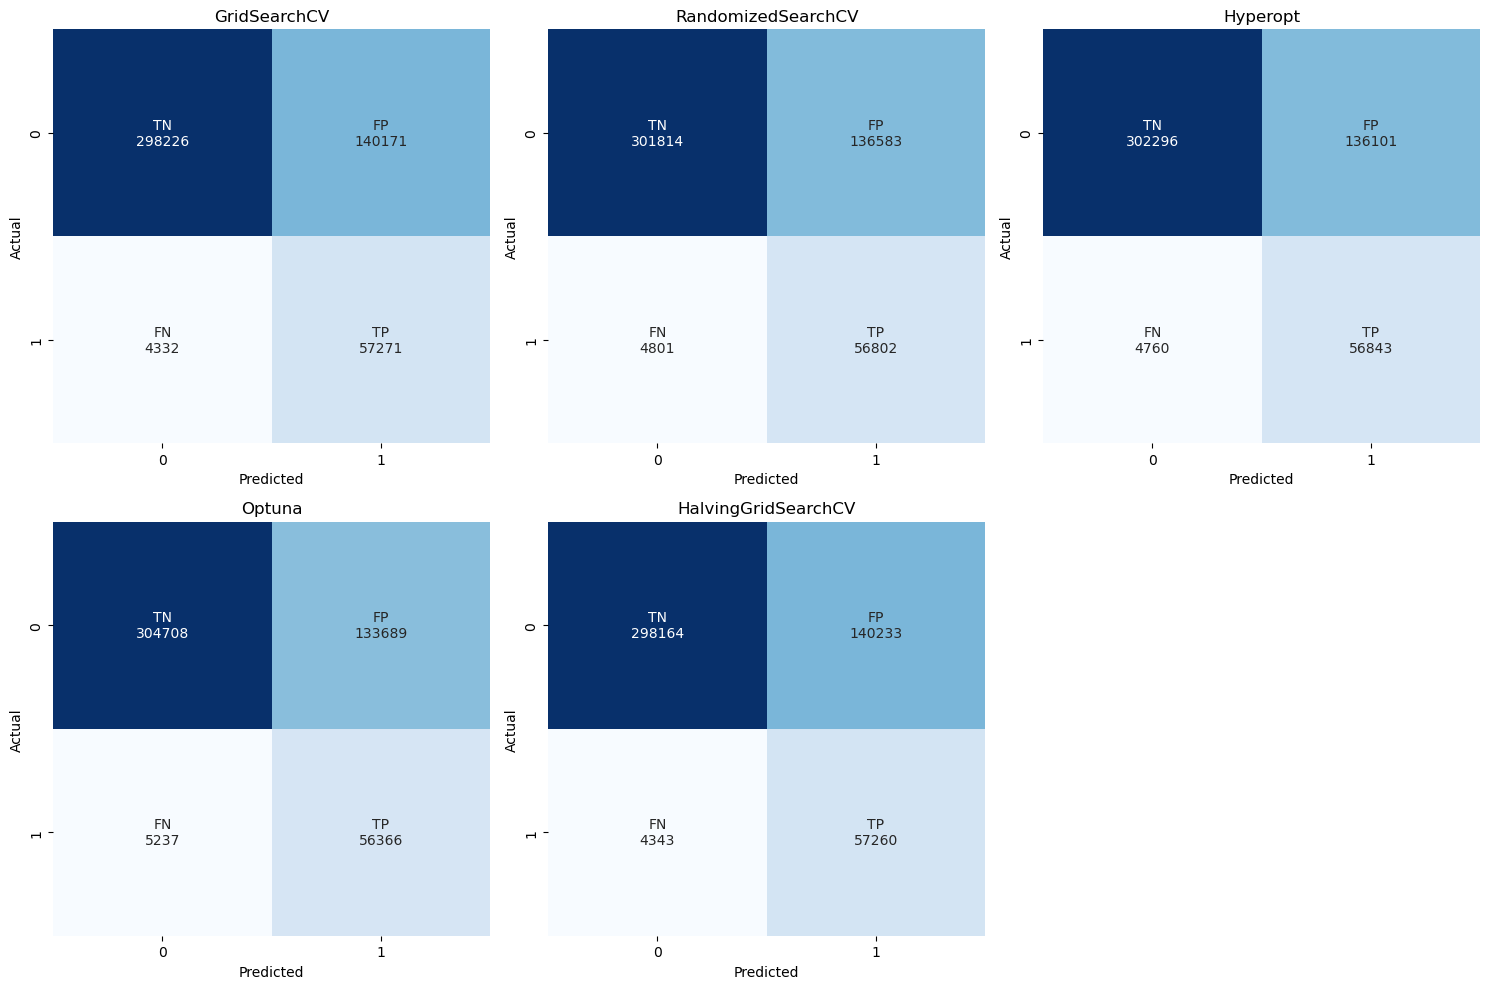

In [31]:
# Сортируем по F1-score (по убыванию)
results_df = results_df.sort_values('F1', ascending=False, key=lambda col: col.replace('ERROR', -1) if col.dtype != 'object' else col)

# Выводим таблицу
print("\n" + "="*80)
print("СРАВНЕНИЕ МЕТОДОВ ПОДБОРА ГИПЕРПАРАМЕТРОВ")
print("="*80)
print(results_df.to_string(index=False))

# Выводим лучший метод
best_method = results_df.iloc[0]
print(f"\nЛучший метод: {best_method['Method']}")
print(f"  F1-Score: {best_method['F1']}")
print(f"  Precision: {best_method['Precision']}")
print(f"  Recall: {best_method['Recall']}")

# Создаем confusion matrices для всех методов
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, (method_name, model_data) in enumerate(all_models_data.items()):
    row = idx // 3
    col = idx % 3
    
    # Получаем предсказания
    y_pred = model_data['y_pred']
    cm = confusion_matrix(y_test, y_pred)
    
    # Аннотации TN, FP, FN, TP
    tn, fp, fn, tp = cm.ravel()
    annot = np.array([[f'TN\n{tn}', f'FP\n{fp}'],
                      [f'FN\n{fn}', f'TP\n{tp}']])
    
    # Heatmap
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', ax=axes[row, col], cbar=False)
    axes[row, col].set_title(method_name)
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('Actual')

# Скрываем последний пустой subplot если нужно
if len(all_models_data) < 6:
    axes[1, 2].set_visible(False)

plt.tight_layout()
plt.show()

### Время подбора гиперпараметров

GridSearchCV, RandomizedSearchCV - 90мин <br/>

Optuna, Hyperopt - 12 часов <br/>

HalvingGridSearchCV - 50 минут